In [49]:
import numpy as np
import numpy.ma as ma
import astropy
from astropy import io
from astropy.io import fits
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.modeling.models import Gaussian2D
from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import WCSAxesSubplot
from PIL import Image
from astropy import units as u
from astropy.cosmology import WMAP5, WMAP7
from astropy.coordinates import Distance

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib as mpl
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
import os

import scipy.ndimage
import scipy.stats as sci
import matplotlib.gridspec as gridspec
import numpy.ma as ma
import re

import marvin
from marvin.tools import Maps
import marvin.utils.plot.map as mapplot
from marvin.tools import Cube
from marvin.tools.vacs import VACs
from marvin.utils.general import get_drpall_table

In [59]:
galaxy_id = '8312-12702' # galaxy

In [95]:
def galaxy_basics(ID):
    
    save_directory = 'Plots/%s' %ID
    os.makedirs(save_directory, exist_ok=True)
    
    maps = Maps(galaxy_id) # initializing Marvin Maps object, which is a set of DAP (Data Analysis Pipeline) maps for the galaxy
    
    masks, fig, axes = maps.get_bpt() #creating BPT diagram, which is used to classify emission in different spaxels based on excitation method
    bpt_example_name = 'Plots/%s/bpt_%s.pdf' %(ID,ID) # naming BPT Diagram figure
    fig.savefig(bpt_example_name, bbox_inches='tight') # saving BPT Diagram figure
    
    ha = maps.emline_gflux_ha_6564 # accessing and creating H-alpha Map object, an individual map of the H-alpha emission line flux
    hb = maps.emline_gflux_hb_4862 # accessing and creating H-beta Map object, an individual map of the H-beta emission line flux
    
    data = get_drpall_table() # extracting DRPall table; result will be an astropy table
    galaxy_DRP = data[data['plateifu'] == galaxy_id] # Finding row where 'plateifu' is equal to galaxy_id and making it into its own astropy table
    
    redshift = galaxy_DRP['z'][0] # extracting galaxy's redshift from DRPall table
    d = Distance(z=redshift,cosmology=WMAP7,allow_negative=1) # computing distance to galaxy using redshift from DRPall table; result will be in Mpc
    D = float(Distance(d, u.cm)/Distance(1, u.cm)) #converting distance d from Mpc to cm, since flux of h-alpha has cm^2 in units, and then making it dimensioneless by dividng by 1cm
    
    Radius = maps.spx_ellcoo_r_re
    
    return(maps, galaxy_DRP, D, Radius, ha, hb)

[WARNING]:  (MatplotlibDeprecationWarning)


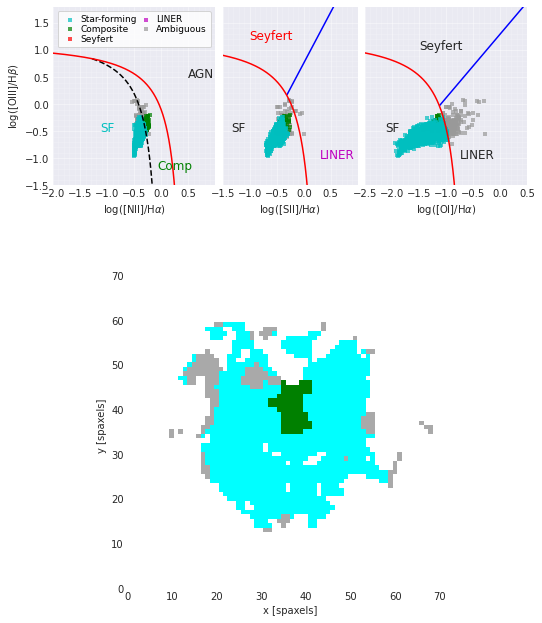

In [96]:
maps, galaxy_data, D, radius, ha, hb = galaxy_basics(galaxy_id)

The Marvin BPT diagrams make use of the classification system defined by Kewley et al. (2006) to return classification masks for different ionisation mechanisms. The classification masks are arrays with the same shape as the Maps or Cube (without the spectral dimension) that can be used to select spaxels belonging to a certain excitation process (e.g., star forming). See https://sdss-marvin.readthedocs.io/en/latest/tools/bpt.html for more information

In [65]:
galaxy_data # Outputting astropy table of galaxy info

plate,ifudsgn,plateifu,mangaid,versdrp2,versdrp3,verscore,versutil,versprim,platetyp,srvymode,objra,objdec,ifuglon,ifuglat,ifura,ifudec,ebvgal,nexp,exptime,drp3qual,bluesn2,redsn2,harname,frlplug,cartid,designid,cenra,cendec,airmsmin,airmsmed,airmsmax,seemin,seemed,seemax,transmin,transmed,transmax,mjdmin,mjdmed,mjdmax,gfwhm,rfwhm,ifwhm,zfwhm,mngtarg1,mngtarg2,mngtarg3,catidnum,plttarg,manga_tileid,nsa_iauname,ifudesignsize,ifutargetsize,ifudesignwrongsize,z,zmin,zmax,szmin,szmax,ezmin,ezmax,probs,pweight,psweight,psrweight,sweight,srweight,eweight,esweight,esrweight,nsa_field,nsa_run,nsa_camcol,nsa_version,nsa_nsaid,nsa_nsaid_v1b,nsa_z,nsa_zdist,nsa_sersic_absmag [7],nsa_elpetro_absmag [7],nsa_elpetro_amivar [7],nsa_sersic_mass,nsa_elpetro_mass,nsa_elpetro_ba,nsa_elpetro_phi,nsa_extinction [7],nsa_elpetro_th50_r,nsa_petro_th50,nsa_petro_flux [7],nsa_petro_flux_ivar [7],nsa_elpetro_flux [7],nsa_elpetro_flux_ivar [7],nsa_sersic_ba,nsa_sersic_n,nsa_sersic_phi,nsa_sersic_th50,nsa_sersic_flux [7],nsa_sersic_flux_ivar [7]
int64,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,bytes53,int64,bytes32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,bytes32,int64,bytes19,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,bytes6,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
8312,12702,8312-12702,1-210923,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,APOGEE-2&MaNGA,MaNGA dither,245.270870484,39.9173908047,63.4154184607,45.1513951004,245.27087,39.917391,0.00939596,9,8100.7,0,25.3565,47.8068,ma088,25,4,8825,246.21668,40.560646,1.01742,1.08002,1.22152,1.19131,1.51398,1.8501,0.795414,0.814963,0.838842,57160,57160,57160,2.46643,2.45647,2.47658,2.47913,1168,0,0,1,plateTargets-1.par,6355,J162105.00+395502.6,127,127,0,0.0320253,0.0260906,0.0357336,0.0534757,0.0585108,0.0249091,0.0365593,0.67973,0.700556,0.299122,0.32231,-999.0,-999.0,0.585061,0.275869,0.295475,230,3225,2,v1_0_1,223182,-999,0.0320253,0.0324744,-17.0659 .. -21.3141,-17.0519 .. -21.26,26.8663 .. 573.301,20997400000.0,18417600000.0,0.728413,125.616,0.0803744 .. 0.0143394,8.66776,7.67477,59.4043 .. 3129.45,0.0102164 .. 0.000190655,61.9348 .. 3231.35,0.00862716 .. 0.000133719,0.703901,1.13261,124.186,8.96928,62.9235 .. 3395.91,0.027788 .. 0.00217478


(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:title={'center':'Emission line Gaussian flux: H-beta 4862'}, xlabel='spaxel', ylabel='spaxel'>)

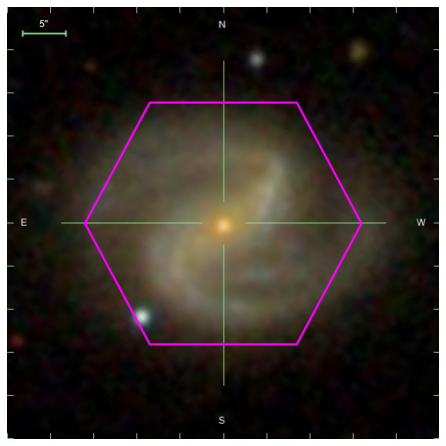

[WARNING]: Warning: converting a masked element to nan. (UserWarning)


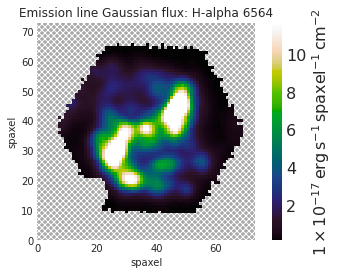

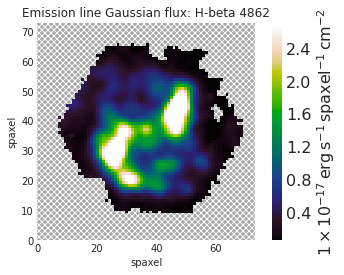

In [70]:
image = Maps.getImage(maps) # retrieving optical image of galaxy stored in Maps object
image.plot() # plotting optical image
ha.plot() # plotting map of H-alpha emission line flux
hb.plot() # plotting map of H-alpha emission line flux

# Calculating dust extinction from the Balmer Decrement

In [77]:
'''Defining function that calculates dust extinction using the Balmer Decrement'''

def extinction(Ha,Hb):
    
    balmer_dec = Ha/Hb
    #balmer_dec.plot(cblabel=r'Flux Ratio (1e-17 erg s$^{-1}$ spaxel$^{-1}$ cm$^{-2}$)')

    A = 2.57 * 2.33 * np.log10(balmer_dec / 2.86)  # k is the extininction curve; for H-alpha, 2.517
                                # is the extinction curve but it varies for different wavelengths
    
    
    return(balmer_dec, A)

In [78]:
bd, ha_extinction = extinction(ha,hb)

# Calculating SFR

In [110]:
'''Defining fucntion that calculates and creates scatter plots of dust-corrected luminosity and SFR as functions of radius for a given galaxy'''

def SFR(ID, Ha, dist, Ha_extinction):
    
    log_L = np.log10(ha)-17+np.log10(4*np.pi*(dist**2)) # computing uncorrected H-alpha luminosity on log scale
    
    # CREATING MASK FOR DATA
    sf = masks['sf']['global']
    mask_non_sf = ~sf * log_L.pixmask.labels_to_value('DONOTUSE')
    mask_bad_data = log_L.pixmask.get_mask("UNRELIABLE")
    high_snr = mapplot.mask_low_snr(value=ha.value, ivar=ha.ivar, snr_min=3)
    neg_values = mapplot.mask_neg_values(value=ha_extinction.value)
    master_mask = mask_non_sf | mask_bad_data | high_snr | neg_values #Combine to make a master mask
    
    
    # COMPUTING AND PLOTTING DUST-CORRECTED LUMINOSITY
    plt.figure(1)
    log_L_corr = log_L.value + 0.4*Ha_extinction.value # computing corrected H-alpha luminosity
    plt.scatter(radius.value[master_mask==0],log_L_corr[master_mask==0],s=0.75)
    plt.title('Scatter Plot of Dust-Corrected Luminosity as a Function of \n Effective Radius for Galaxy %s' %ID)
    plt.xlabel(r'$ R/R_{eff} $')
    plt.ylabel(r'$ log(L) (corrected luminosity) $')
    plt.ylim(37.5,39.5)
    lum_scatter_example_name = 'Plots/%s/luminosity_corrected_%s.pdf' %(ID, ID) 
    plt.savefig(lum_scatter_example_name, bbox_inches='tight')
    
    # COMPUTING AND PLOTTING SFR
    plt.figure(2)
    log_SFR = log_L_corr - 41.27 # 41.27 is the calibration constant for Ha
    plt.scatter(radius.value[master_mask==0],log_SFR[master_mask==0],s=0.75)
    plt.ylim(-4,-1.5)
    plt.title('Scatter Plot of SFR as a Function of Effective Radius \n for Galaxy %s' %ID)
    plt.xlabel(r'$ R/R_{eff} $')
    plt.ylabel(r'$ log(SFR) $')
    sfr_scatter_example_name = 'Plots/%s/sfr_scatter_example_%s.pdf' %(ID, ID)
    plt.savefig(sfr_scatter_example_name, bbox_inches='tight')
    
    sfr_mean,radius_mean,binnumber = sci.binned_statistic(radius.value[master_mask==0],log_SFR[master_mask==0],bins=10,range=[0,2.5])
    
    # FINDING THE BINNED AVERAGE SFR BY RADIUS FOR THE GALAXY
    plt.figure(3)
    plt.plot(radius_mean[:-1], sfr_mean)
    plt.xlim(0,2.5)
    plt.title('Average SFR as a Function of Effective Radius \n for Galaxy %s' %ID)
    plt.xlabel(r'$ R/R_{eff}$')
    plt.ylabel('Mean SFR (logscale)')
    sfr_mean_example_name = 'Plots/%s/sfr_mean_binned_example_%s.pdf' %(ID, ID)
    plt.savefig(sfr_mean_example_name, bbox_inches='tight')
    
    plt.figure(4)
    plt.scatter(radius.value[master_mask==0],log_SFR[master_mask==0], color='powderblue', label='SFR')
    plt.plot(radius_mean[:-1], sfr_mean, alpha=1, color='cadetblue', label='Mean SFR')
    plt.title('SFR and Binned Mean SFR as a Function of Effective Radius \n for Galaxy %s' % (galaxy_id))
    plt.xlim(0,2.3)
    plt.xlabel(r'$ R/R_{eff}$')
    plt.ylabel('SFR (logscale)')
    plt.legend()
    sfr_both_example_name = 'Plots/%s/sfr_both_binned_example_%s.pdf' %(ID, ID)
    plt.savefig(sfr_both_example_name, bbox_inches='tight')
    
    return(log_L, master_mask)

[WARNING]: divide by zero encountered in power (RuntimeWarning)
[WARNING]: divide by zero encountered in log10 (RuntimeWarning)
[WARNING]: invalid value encountered in log10 (RuntimeWarning)


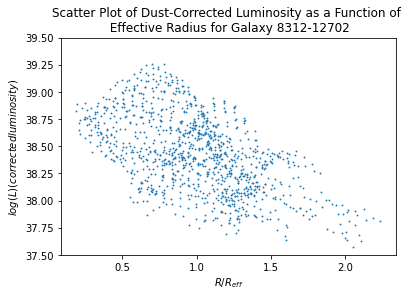

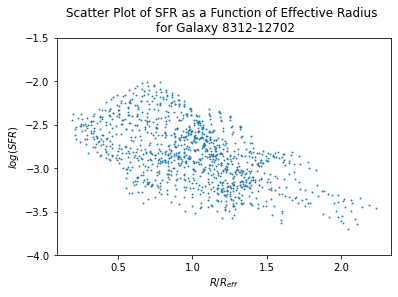

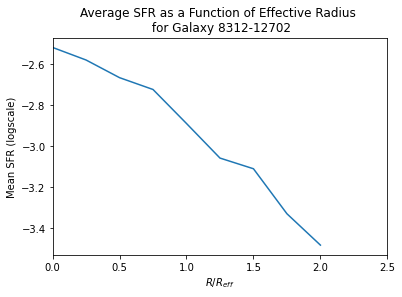

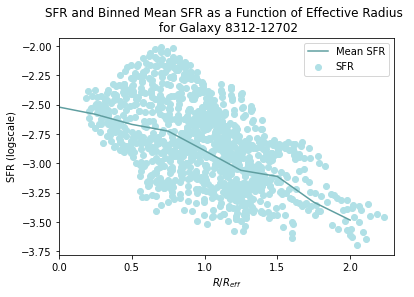

In [111]:
sfr = SFR(galaxy_id, ha, D, ha_extinction)